In [55]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam, Adamax, Ftrl

In [56]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel('/kaggle/input/btc-data/btc_processed_data.xlsx')
df1=df.reset_index()['Close']

In [57]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [58]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [59]:
test_size,train_size

(576, 1343)

In [60]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1 + 1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [61]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)

combined_data = np.concatenate((train_data[-time_step:], test_data))
X_test, ytest = create_dataset(combined_data, time_step)

In [62]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
ytest = ytest.reshape(-1, 1)

In [63]:
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", ytest.shape)

x_train shape: (1243, 100, 1)
y_train shape: (1243,)
x_test shape: (576, 100, 1)
y_test shape: (576, 1)


In [64]:
ftrl_optimizer = Ftrl(learning_rate=0.01, l1_regularization_strength=0.0, l2_regularization_strength=0.0)

In [65]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=ftrl_optimizer)

# Print model summary (optional)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1598 - val_loss: 0.2040
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1211 - val_loss: 0.1800
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1113 - val_loss: 0.1638
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1032 - val_loss: 0.1515
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0951 - val_loss: 0.1418
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0968 - val_loss: 0.1337
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0886 - val_loss: 0.1269
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0863 - val_loss: 0.1211
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0785 - val_loss: 0.1162
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0769 - val_loss: 0.1118
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0770 - val_loss: 0.1079
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

In [67]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [68]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest)

In [69]:
# EVALUATION
from sklearn.metrics import mean_squared_error, mean_absolute_error


test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

test_mae = mean_absolute_error(ytest, y_pred)

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Testing RMSE: {test_rmse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing MAPE: {test_mape}%")

Testing RMSE: 18392.053271386754
Testing MAE: 12258.083068847656
Testing MAPE: 28.736645364646613%


<h2> Predict 30, 60, 90 days

In [70]:
def predict_days(model, start_input, n_steps, predict_days):
    temp_input = list(start_input)
    temp_input = temp_input[0].tolist()

    lst_output = []
    i = 0
    while i < predict_days:
        if len(temp_input) > n_steps:
            x_input = np.array(temp_input[-n_steps:])
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1

    return lst_output

In [71]:
n_steps = 100

# Get the last 100 data points from the test data
x_input = test_data[-100:].reshape(1, -1)

# Predict 30, 60, and 90 days ahead
output_30_days = predict_days(model, x_input, n_steps, 30)
output_60_days = predict_days(model, x_input, n_steps, 60)
output_90_days = predict_days(model, x_input, n_steps, 90)

output_30_days = np.array(output_30_days).reshape(-1, 1)
output_60_days = np.array(output_60_days).reshape(-1, 1)
output_90_days = np.array(output_90_days).reshape(-1, 1)

output_30_days = scaler.inverse_transform(output_30_days)
output_60_days = scaler.inverse_transform(output_60_days)
output_90_days = scaler.inverse_transform(output_90_days)

<h3> Visualize

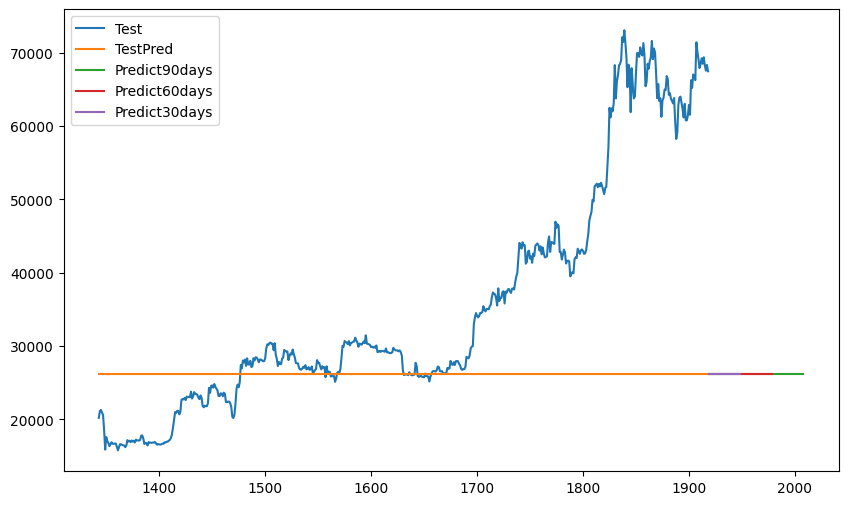

In [72]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
predict_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
predict_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
predict_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)

plt.figure(figsize=(10, 6))

plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred, label='TestPred')
plt.plot(predict_90_days_index, output_90_days, label='Predict90days')
plt.plot(predict_60_days_index, output_60_days, label='Predict60days')
plt.plot(predict_30_days_index, output_30_days, label='Predict30days')

plt.legend()
plt.show()